# Getting the Data

In [1]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

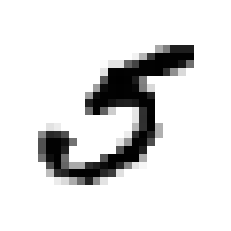

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

someDigit = X[36000]
someDigitImage = someDigit.reshape(28, 28)

plt.imshow(someDigitImage, cmap=matplotlib.cm.binary,
          interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
y[36000]

5

In [8]:
def showDigits(instances, imagesPerRow=10, **options):
    size = 28
    imagesPerRow = min(len(instances), imagesPerRow)
    images = [instance.reshape(size, size) for instance in instances]
    nRows = (len(instances) - 1) // imagesPerRow+1
    rowImages = []
    nEmpty = nRows * imagesPerRow - len(instances)
    images.append(np.zeros((size, size*nEmpty)))
    for row in range(nRows):
        rImages = images[row*imagesPerRow : (row+1)*imagesPerRow]
        rowImages.append(np.concatenate(rImages, axis=1))
    image = np.concatenate(rowImages, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis('off')

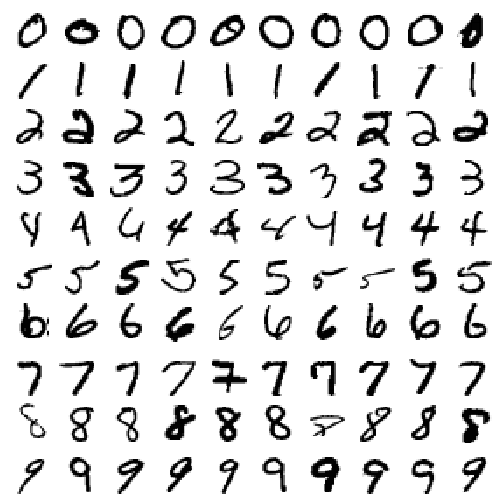

In [9]:
plt.figure(figsize=(9, 9))
exampleImages = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
showDigits(exampleImages, imagesPerRow=10)

In the mnist dataset, data is already split into train and test. Values till 60,000 are train data and the rest are test data.

In [10]:
XTrain, yTrain, XTest, yTest = X[:60000], y[:60000], X[60000:], y[60000:]

In [11]:
shuffleIndex = np.random.permutation(60000)
XTrain, yTrain = XTrain[shuffleIndex], yTrain[shuffleIndex]

# Training a Binary Classifier

In [12]:
yTrain5 = (yTrain == 5)
yTest5 = (yTest == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgdClf = SGDClassifier(random_state=42)
sgdClf.fit(XTrain, yTrain5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgdClf.predict([someDigit])

array([False])

# Performance Measures

## Measuring Accuracy using Cross-Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for trainIndex, testIndex in skfolds.split(XTrain, yTrain5):
    cloneClf = clone(sgdClf)
    XTrainFolds = XTrain[trainIndex]
    XTestFolds = XTrain[testIndex]
    yTrainFolds = yTrain5[trainIndex]
    yTestFolds = yTrain5[testIndex]
    
    cloneClf.fit(XTrainFolds, yTrainFolds)
    yPred = cloneClf.predict(XTestFolds)
    nCorrect = sum(yPred == yTestFolds)
    print(nCorrect/len(yPred))

c:\users\raghhuveer jaikanth\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.96105
0.9682
0.96875


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgdClf, XTrain, yTrain5, cv=3, scoring='accuracy')

array([0.96105, 0.9682 , 0.96875])

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5Clf = Never5Classifier()
cross_val_score(never5Clf, XTrain, yTrain5, cv=3, scoring='accuracy')

array([0.90905, 0.91145, 0.90845])

## Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict
yTrainPred = cross_val_predict(sgdClf, XTrain, yTrain5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(yTrain5, yTrainPred)

array([[53583,   996],
       [ 1044,  4377]], dtype=int64)

In confusion matrix - 

[true-ve,  false+ve],

[true+ve,  false-ve]

In [20]:
yTrainPerfect = yTrain5
confusion_matrix(yTrain5, yTrainPerfect)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(yTrain5, yTrainPred))
print(recall_score(yTrain5, yTrainPred))

0.8146286990508096
0.8074156059767571


In [22]:
from sklearn.metrics import f1_score

print(f1_score(yTrain5, yTrainPred))

0.8110061145080601


## Precision-Recall TradeOff

In [23]:
yScores = sgdClf.decision_function([someDigit])
yScores

array([-1521.87486642])

In [24]:
threshold = 0
ySomeDigitPred = (yScores > threshold)
ySomeDigitPred

array([False])

In [25]:
threshold = 20000
ySomeDigitPred = (yScores > threshold)
ySomeDigitPred

array([False])

In [26]:
yScores = cross_val_predict(sgdClf, XTrain, yTrain5, cv=3, 
                            method='decision_function')

In [27]:
yScores

array([ -1867.78482995,  -9779.3616899 ,  -3688.08434935, ...,
       -20580.04966341,  -9245.22098201,  -9442.07005809])

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(yTrain5, yScores)

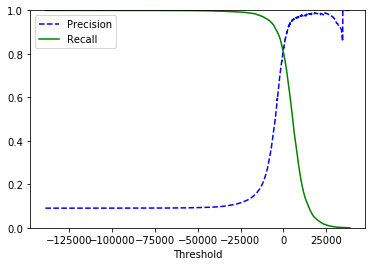

In [29]:
def plotPrecisionRecallvsThreshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plotPrecisionRecallvsThreshold(precisions, recalls, thresholds)
plt.show()

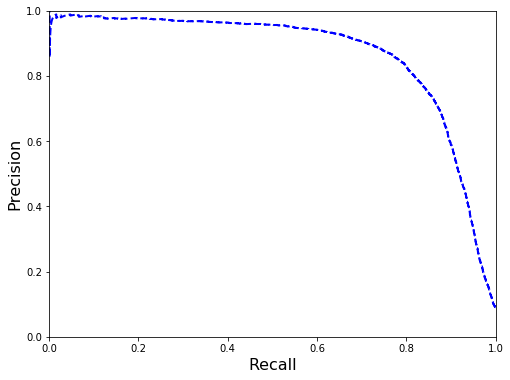

In [30]:
def plotPrecisionvsRecall(precisions, recalls):
    plt.plot(recalls, precisions, 'b--', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8, 6))
plotPrecisionvsRecall(precisions, recalls)
plt.show()

In [31]:
yTrainPred90 = (yScores > 7000)

In [32]:
print(precision_score(yTrain5, yTrainPred90))
print(recall_score(yTrain5, yTrainPred90))

0.9631929046563192
0.4006640841173215


## ROC Curve

Recieving Operator Charateristic Curve. It plots the true positive rate(specificity) to the false positive rate(1 - specificity). 

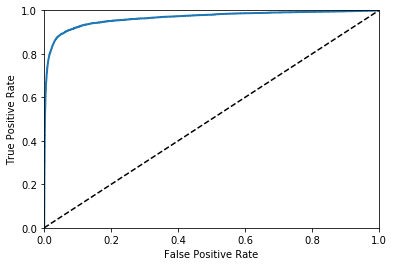

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(yTrain5, yScores)

def plotROCcurve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plotROCcurve(fpr, tpr)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(yTrain5, yScores)

0.9650184388891306

Let us train a Random Forest Classifier to compare ROC curves and scores with the SGDClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

forestClf = RandomForestClassifier(random_state=42)
yProbForest = cross_val_predict(forestClf, XTrain, yTrain5, cv=3,
                                method='predict_proba')

In [36]:
yScoresForest = yProbForest[:, 1]
fprForest, tprForest, thresholdsForest = roc_curve(yTrain5, yScoresForest)

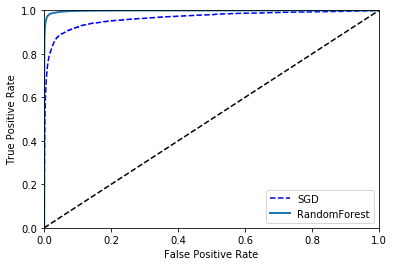

In [37]:
plt.plot(fpr, tpr, 'b--', label='SGD')
plotROCcurve(fprForest, tprForest, 'RandomForest')
plt.legend(loc='lower right')
plt.show()

In [38]:
roc_auc_score(yTrain5, yScoresForest)

0.9983943638420595

In [39]:
yTrainPredForest = cross_val_predict(forestClf, XTrain, yTrain5, cv=3)

print(precision_score(yTrain5, yTrainPredForest))
print(recall_score(yTrain5, yTrainPredForest))

0.9901673640167364
0.8730861464674414


# Multi-class Classification

In [41]:
sgdClf.fit(XTrain, yTrain)
sgdClf.predict([someDigit])

array([5], dtype=int8)

In [42]:
someDigitScore = sgdClf.decision_function([someDigit])
someDigitScore

array([[ -9925.12175423, -35443.37237824,   -991.02389877,
         -5370.70196115, -19432.82697728,   -500.58307134,
        -31377.86973855, -17854.50534792, -11885.51667577,
        -12126.65987419]])

In [43]:
np.argmax(someDigitScore)

5

In [44]:
sgdClf.classes_[np.argmax(someDigitScore)]

5

There are 2 ways to do multi-class classification - 

<b>1. One-vs-All</b> => Makes sure one there are n classifier if there are n classes,                  with each classifier considering only it's class as +ve

<b>2. One-vs-One</b> => Makes sure there are n(n-1)/2 classifiers. Each classifier                      distinguishes b/w 2 classes (E.g - 1vs2, 1vs3, 1vs4... and so                  on)

In [45]:
from sklearn.multiclass import OneVsOneClassifier
ovoClf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovoClf.fit(XTrain, yTrain)
ovoClf.predict([someDigit])

array([5], dtype=int8)

In [46]:
len(ovoClf.estimators_)

45

In [47]:
forestClf.fit(XTrain, yTrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
forestClf.predict([someDigit])

array([5], dtype=int8)

In [49]:
forestClf.predict_proba([someDigit])

array([[0.  , 0.  , 0.  , 0.04, 0.  , 0.93, 0.  , 0.01, 0.02, 0.  ]])

In [50]:
cross_val_score(forestClf, XTrain, yTrain, cv=3, scoring='accuracy')

array([0.9675 , 0.9662 , 0.96525])

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
XTrainScaled = scaler.fit_transform(XTrain.astype(np.float64))
cross_val_score(sgdClf, XTrainScaled, yTrain, cv=3, scoring='accuracy')

array([0.89855, 0.89755, 0.90445])

# Error Analysis

In [52]:
yTrainPred = cross_val_predict(sgdClf, XTrainScaled, yTrain, cv=3)
confMx = confusion_matrix(yTrain, yTrainPred)
confMx

array([[5588,    0,   19,    5,    8,   36,   31,    7,  228,    1],
       [   0, 6419,   43,   23,    3,   44,    4,    8,  184,   14],
       [  28,   27, 5232,   94,   75,   24,   65,   38,  365,   10],
       [  25,   22,  112, 5220,    2,  201,   28,   48,  408,   65],
       [  12,   15,   42,   13, 5231,    9,   32,   21,  316,  151],
       [  24,   20,   29,  155,   48, 4488,   77,   13,  504,   63],
       [  31,   17,   42,    2,   38,   81, 5566,    6,  134,    1],
       [  22,    9,   52,   17,   45,    9,    4, 5713,  181,  213],
       [  16,   66,   37,  105,    3,  123,   29,    7, 5419,   46],
       [  21,   22,   28,   59,  126,   36,    1,  171,  350, 5135]],
      dtype=int64)

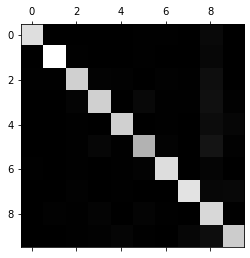

In [53]:
plt.matshow(confMx, cmap=plt.cm.gray)
plt.show()

In [54]:
rowSums = confMx.sum(axis=1, keepdims=True)
normConfMx = confMx/rowSums

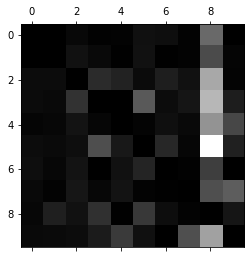

In [55]:
np.fill_diagonal(normConfMx, 0)
plt.matshow(normConfMx, cmap=plt.cm.gray)
plt.show()

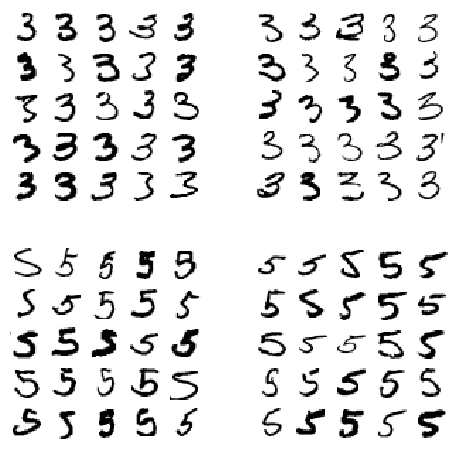

In [56]:
clA, clB = 3, 5
X_aa = XTrain[(yTrain == clA) & (yTrainPred == clA)]
X_ab = XTrain[(yTrain == clA) & (yTrainPred == clB)]
X_ba = XTrain[(yTrain == clB) & (yTrainPred == clA)]
X_bb = XTrain[(yTrain == clB) & (yTrainPred == clB)]
              
plt.figure(figsize=(8, 8))
plt.subplot(221); showDigits(X_aa[:25], imagesPerRow=5)
plt.subplot(222); showDigits(X_ab[:25], imagesPerRow=5)
plt.subplot(223); showDigits(X_ba[:25], imagesPerRow=5)
plt.subplot(224); showDigits(X_bb[:25], imagesPerRow=5)

# Multilabel Classification

In [57]:
from sklearn. neighbors import KNeighborsClassifier

yTrainLarge = (yTrain >= 7)
yTrainOdd = (yTrain%2 == 1)
yMultiLabel = np.c_[yTrainLarge, yTrainOdd]

knnClf = KNeighborsClassifier()
knnClf.fit(XTrain, yMultiLabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [58]:
knnClf.predict([someDigit])

array([[False,  True]])

In [59]:
yTrainKnnPred = cross_val_predict(knnClf, XTrain, yTrain, cv=3, n_jobs=-1)
f1_score(yTrain, yTrainKnnPred, average='macro')

0.9682596306280915

# MultiOutput Classification

In [60]:
noise = np.random.randint(0, 100, (len(XTrain), 784))
XTrainMod = XTrain + noise
noise = np.random.randint(0, 100, (len(XTest), 784))
XTestMod = XTest + noise
yTrainMod = XTrain
yTestMod = XTest

In [61]:
def showDigit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary,
              interpolation='nearest')
    plt.axis('off')

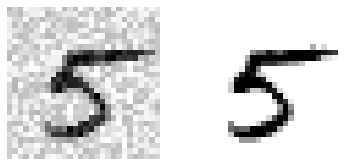

In [62]:
someIndex = 5500
plt.subplot(121); showDigit(XTestMod[someIndex])
plt.subplot(122); showDigit(yTestMod[someIndex])

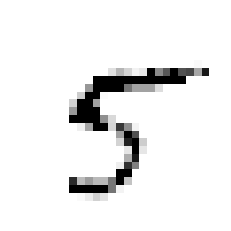

In [63]:
knnClf.fit(XTrainMod, yTrainMod)
cleanDigit = knnClf.predict([XTestMod[someIndex]])
showDigit(cleanDigit)

# Exercises

## Exercise 1 - 

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [116]:
from sklearn.model_selection import GridSearchCV

paramGrid = [{
    'weights': ["uniform", "distance"],
    'n_neighbours': [3,4,5]
}]
param_grid = [{
    'weights': ["uniform", "distance"], 
    'n_neighbors': [3, 4, 5]
}]

knnClf = KNeighborsClassifier()
gridSearch = GridSearchCV(knnClf, paramGrid, cv=5, verbose=3, n_jobs=-1)
gridSearch.fit(XTrain, yTrain)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Invalid parameter n_neighbours for estimator KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'). Check the list of available parameters with `estimator.get_params().keys()`.

In [119]:
KNeighborsClassifier.get_params().keys()

TypeError: get_params() missing 1 required positional argument: 'self'